# Binary star evolution and binary black holes

All the relevant information for the project are to be found in the pdf document present in the repo.
Note that you are assigned to project 1 (as the title said).

## Datasets 

Datasets are stored on Google Drive (link and description in the pdf document)

### Contacts

* Michela Mapelli <michela.mapelli@unipd.it>


In [113]:
import pandas as pd
import numpy as np
import string
import glob
import os
import seaborn as sns
import sklearn
from sklearn.neural_network import MLPClassifier

**Ognuno di voi dovrebbe provare a runnare os.getlogin() per vedere cosa esce, poi metterlo nell'if e aggiornare il path di conseguenza, così eliminiamo il lavoro di cambio di directory ogni volta. (Ho provato a fare un guess del path di Tommaso).**

In [2]:
# personalized computer settings

hname = os.getlogin()
path = ''

if hname=='paolozinesi': path = '/Users/paolozinesi/Downloads/Project_LCP_A/stable_MT_vs_CE/'
if hname=='tommaso': path = "/Users/tommaso/Desktop/MagistraleI/TheFormationOfBinaryBlackHoles_data/lab_data/stable_MT_vs_CE/"
#if hname=='NICOLAZOMER': path = "PATHDINICOLA"
#if hname=='ANDREALAZZARI': path = "PATHDIANDREA"

In [3]:
alpha_values = [0.5, 1, 3, 5]
met_values = [0.02, 0.002, 0.0002, 0.004, 0.0004, 0.006, 0.008, 0.012, 0.0012, 0.016, 0.0016]

frame = pd.DataFrame(data=None, columns=['col.0:ID','col.1:m1ZAMS/Msun','col.3:m1rem/Msun','col.4:m2rem/Msun',  'col.6:delay_time/Myr', 'col.7:sma/Rsun', 'col.8:ecc', 'col.21:CE'])

for alpha in alpha_values:
    for met in met_values:
        for name in glob.glob(path+f'A{alpha}/MTCE_BBHs_{met}*'):
        #for name in glob.glob(f'/Users/tommaso/Desktop/MagistraleI/TheFormationOfBinaryBlackHoles_data/lab_data/stable_MT_vs_CE/A{alpha}/MTCE_BBHs_{met}*'):    
        #for name in glob.glob(f'/data/TheFormationOfBinaryBlackHoles_data/stable_MT_vs_CE/A{alpha}/MTCE_BBHs_{met}*'):
            df = pd.read_csv(name, skiprows=2, header=0, sep=' ')
            df = df.loc[:,['col.0:ID','col.1:m1ZAMS/Msun','col.3:m1rem/Msun','col.4:m2rem/Msun',  'col.6:delay_time/Myr', 'col.7:sma/Rsun', 'col.8:ecc', 'col.21:CE']]
            met_array = np.ones((df.shape[0], 1))*met
            alpha_array = np.ones((df.shape[0],1))*alpha
            df['metallicity'] = met_array
            df['alpha'] = alpha_array
            
            frame = pd.concat([frame, df], axis=0, ignore_index=True)


In [4]:
frame.head()

,col.0:ID,col.1:m1ZAMS/Msun,col.3:m1rem/Msun,col.4:m2rem/Msun,col.6:delay_time/Myr,col.7:sma/Rsun,col.8:ecc,col.21:CE,metallicity,alpha
0,0_6942,50.9151,4.8001,4.7478,2233.6292,7.9524,0.273150,True,0.02,0.5
1,0_80347,57.0253,5.5849,5.5325,1076.5703,9.0222,0.508320,True,0.02,0.5
2,0_158611,91.0594,8.3787,8.2624,6810.4365,14.9810,0.072798,True,0.02,0.5
3,0_211410,117.9396,19.3984,11.2422,7905.6343,11229.0000,0.999640,False,0.02,0.5
4,0_213101,40.2965,3.1045,3.0769,8703.5479,13.7630,0.705290,True,0.02,0.5


In [14]:
#Creating the a dataframe with common envelopes and one with mass transfer
frame_true = frame[(frame['col.21:CE'] == True)] 
frame_true = frame_true.reset_index(drop=True)
frame_false = frame[(frame['col.21:CE'] == False)] 
frame_false = frame_false.reset_index(drop=True)

In [59]:
frame_true.head()



,col.0:ID,col.1:m1ZAMS/Msun,col.3:m1rem/Msun,col.4:m2rem/Msun,col.6:delay_time/Myr,col.7:sma/Rsun,col.8:ecc,col.21:CE,metallicity,alpha
0,0_6942,50.9151,4.8001,4.7478,2233.6292,7.9524,0.273150,True,0.02,0.5
1,0_80347,57.0253,5.5849,5.5325,1076.5703,9.0222,0.508320,True,0.02,0.5
2,0_158611,91.0594,8.3787,8.2624,6810.4365,14.9810,0.072798,True,0.02,0.5
3,0_213101,40.2965,3.1045,3.0769,8703.5479,13.7630,0.705290,True,0.02,0.5
4,0_261642,62.6781,7.5024,5.9658,2895.4182,10.4610,0.163210,True,0.02,0.5


In [60]:
frame_false.head()

,col.0:ID,col.1:m1ZAMS/Msun,col.3:m1rem/Msun,col.4:m2rem/Msun,col.6:delay_time/Myr,col.7:sma/Rsun,col.8:ecc,col.21:CE,metallicity,alpha
0,0_211410,117.9396,19.3984,11.2422,7905.6343,11229.000,0.999640,False,0.020,0.5
1,1_3370919,76.2366,10.0905,8.1532,5914.8696,5378.200,0.999510,False,0.020,0.5
2,1_3601930,123.0264,18.0234,7.6028,9398.3252,3408.700,0.998740,False,0.020,0.5
3,3_2982857,132.6673,20.7397,5.6742,3331.2690,3755.500,0.999260,False,0.020,0.5
4,0_526,75.1587,26.1035,25.6875,12982.4980,41.214,0.009654,False,0.002,0.5


In [7]:
#frame_graph = frame.drop(columns=['col.0:ID'], axis=1)
#sns.pairplot(frame, hue = 'col.21:CE', palette='Set2')

In [8]:
#frame_graph.head()

**!!! WARNING, il blocco sotto ci mette un paio d'ore per runnare**

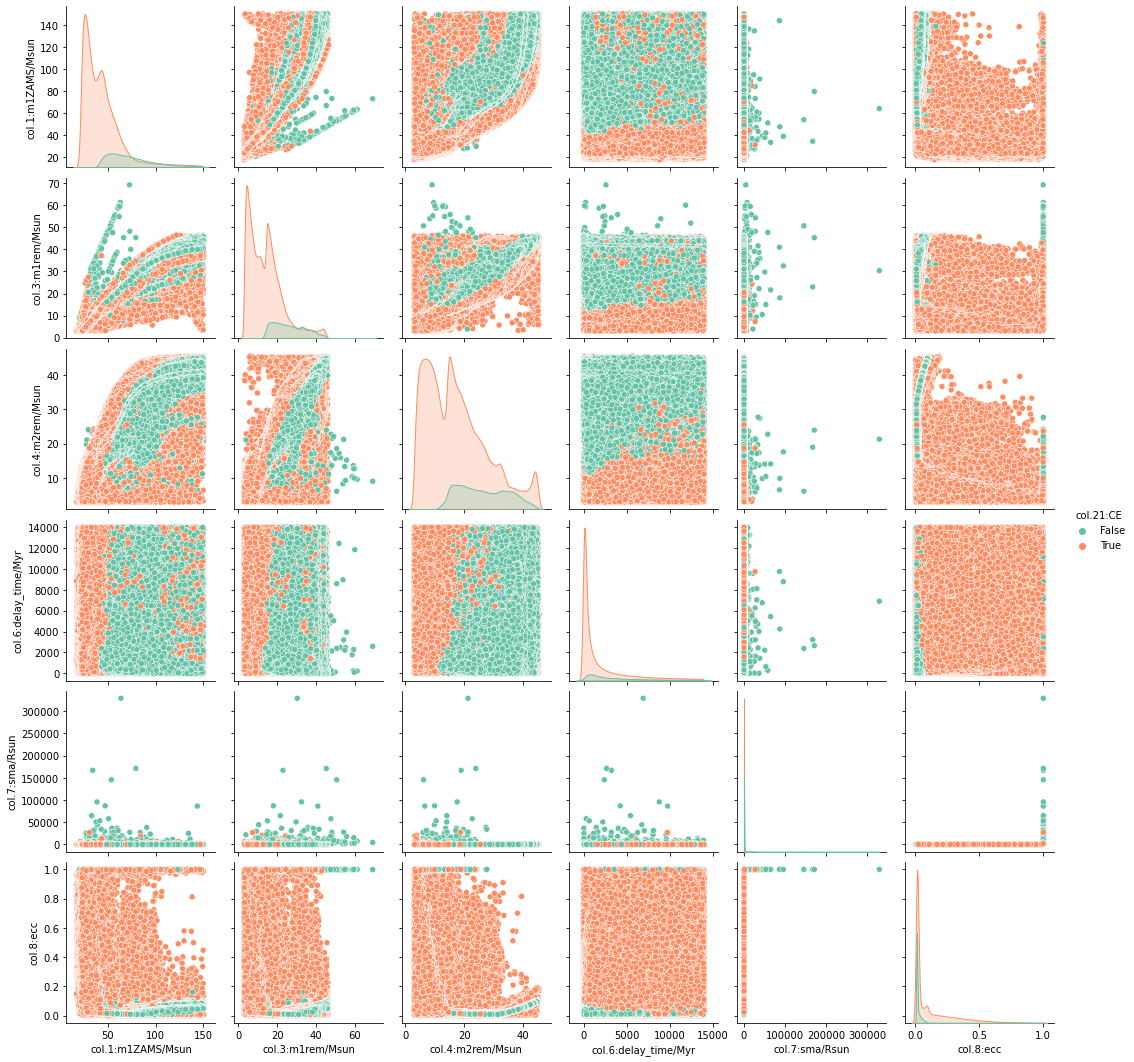

In [9]:



#frame_graph = frame.drop(columns=['col.0:ID', 'metallicity', 'alpha'], axis=1)
#sns.pairplot(frame_graph, hue = 'col.21:CE', palette='Set2')
                    

## ML algorithms

In [106]:
m_train = 20000
m_test = 1000

frame_sample = pd.concat([frame_true.sample(n=int(0.5*(m_train+m_test))),
                          frame_false.sample(n=int(0.5*(m_train+m_test)))], ignore_index=True)

frame_train = frame_sample.iloc[:m_train]
frame_test = frame_sample.iloc[-m_test:]


# convert dataframe into a numpy array
X_train = frame_train.drop(labels=["col.0:ID","col.21:CE"], axis=1).values
Y_train = frame_train["col.21:CE"].apply(lambda x: np.sum(x)).values
X_test = frame_test.drop(labels=["col.0:ID","col.21:CE"], axis=1).values
Y_test = frame_test["col.21:CE"].apply(lambda x: np.sum(x)).values

#### Random Forest

In [109]:
RF_clf = sklearn.ensemble.RandomForestClassifier(max_depth=None)
RF_clf.fit(X_train, Y_train)

train_err = 1 - RF_clf.score(X_train, Y_train)
print("Training error = %1.3f" % train_err)

test_err = 1 - RF_clf.score(X_test, Y_test)
print("Test error = %1.3f" % test_err)

Training error = 0.000
Test error = 0.010


#### SVM

In [110]:
SVM_clf = sklearn.svm.SVC()
SVM_clf.fit(X_train, Y_train)

train_err = 1 - SVM_clf.score(X_train, Y_train)
print("Training error = %1.3f" % train_err)

test_err = 1 - SVM_clf.score(X_test, Y_test)
print("Test error = %1.3f" % test_err)

Training error = 0.281
Test error = 0.145


#### Neural Network

In [131]:
NN_clf = MLPClassifier(hidden_layer_sizes=(50,), learning_rate='adaptive')
NN_clf.fit(X_train, Y_train)

train_err = 1 - NN_clf.score(X_train, Y_train)
print("Training error = %1.3f" % train_err)

test_err = 1 - NN_clf.score(X_test, Y_test)
print("Test error = %1.3f" % test_err)

Training error = 0.080
Test error = 0.082
